# General

In this exercise we will train various small MLPs on predicting IQ from a few other characteristics.
We will explore the concepts of
- mini-batch training and
- training/validation/test split of the data.

You will have to fill in the gaps in the code, run the experiments and prepare results.

## Mini-Batch Training

First, here is the idea behind mini-batch training:
For larger datasets it is computationally disadvantageous to compute gradients for all training examples and then make a full gradient descent step. Instead, we subsample a mini-batch, i.e. a subset of training examples. For them, we compute the forward and backward pass and make a gradient step. One pass through all examples in the training set is called an epoch.

In pseudo-code, we do the following:

- For epoch=1,...
    - Choose minibatches mb_1,...,mb_k that cover the full training set
    - For each minibath mb = {(x'_1,y'_1),...,(x'_l,y'_l)}
        - Compute gradients of loss for each element (x'_i, y'_i) w.r.t. each trainable parameter
        - Make update step

## Data Split

In order to assess generalization error, we split the dataset into a
- training subset (typically ~70 - 80%) that we train on
- a validation subset (typically ~10 - 20%) that we use choose best hyperarameters and pick the right number of training iterations for early stopping
- a test subset (typically ~10%) to estimate generalization error.

**Important**: Never use the test set to tune your model! It cannot influence model selection or training in any way.

First, let us import the needed libraries.

In [25]:
import random
from typing import List

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

Loading data

In [26]:
data = pd.read_csv("gpa_iq.csv")
data.head(5)

,obs,gpa,iq,gender,concept
0,1,7.940,111,2,67
1,2,8.292,107,2,43
2,3,4.643,100,2,52
3,4,7.470,107,2,66
4,5,8.882,114,1,58


Value class

In [27]:
class Value:
    """
    Added `exp` and `pow`
    """

    def __init__(self, data, _children=(), operation="", label=""):
        self.data = data
        self._prev = set(_children)
        self._operation = operation
        self._label = label

        # because we assume that the value doesn't affect the
        # loss function by default, thus the slope is 0.0
        self.grad = 0.0

        # This will store a function which will calculate the
        # local derivative according to the operation and store
        # in the `self.grad` variable.
        self._backward = lambda : None

    def tanh(self):
        x = self.data
        t = (np.exp(2*x) - 1) / (np.exp(2*x) + 1)
        out = Value(t, (self,), "tanh")

        def _backward():
            self.grad += (1 - t ** 2) * out.grad # chain rule here too!
        out._backward = _backward
        return out

    def backward(self):
        topo = []
        visited = set()

        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)

        self.grad = 1.0
        for node in reversed(topo):
            node._backward()


    def __add__(self, other):
        other = Value(other) if not isinstance(other, Value) else other
        out = Value(self.data + other.data, (self, other), '+')
        def _backward():
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad
        out._backward = _backward
        return out


    def __truediv__(self, other):
        other = Value(other) if not isinstance(other, Value) else other
        out =  Value(self.data / other.data, (self, other), '/')
        def _backward():
            self.grad += (1.0 / other.data) * out.grad
            other.grad += self.data * (-1.0 / other.data**2) * out.grad
        out._backward = _backward
        return out


    def __mul__(self, other):
        other = Value(other) if not isinstance(other, Value) else other
        out = Value(self.data * other.data, (self, other), '*')
        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        out._backward = _backward
        return out


    def __sub__(self, other):
        other = Value(other) if not isinstance(other, Value) else other
        out = Value(self.data - other.data, (self, other), '-')
        def _backward():
            self.grad += 1.0 * out.grad
            other.grad += -1.0 * out.grad
        out._backward = _backward
        return out

    def __radd__(self, other):
        return self + other

    def __rmul__(self, other):
        return self * other

    def __rsub__(self, other):
        return self - other

    def __rtruediv__(self, other):
        return self / other

    def __pow__(self, other):
        assert isinstance(other, (int, float)), "Only int/float can be used"
        out = Value(self.data ** other, (self, ), f'**{other}')

        def _backward():
            self.grad += other * (self.data ** (other - 1)) * out.grad # chain rule
        out._backward = _backward
        return out

    def __repr__(self):
        return f"Value(data={self.data})"

Neuron class

In [28]:
class Neuron:
    """
    Making a new function `parameters` which will return ONLY the weights + bias.
    """
    def __init__(self, nin, activate=True):
        self.w = [Value(np.random.uniform(-1, 1), label=f'w{i}') for i in range(nin)]
        self.b = Value(np.random.uniform(-1, 1), label='b')
        self.activate = activate

    def __call__(self, x):
        assert len(x) == len(self.w)
        out = sum(xi*wi for xi, wi in zip(x, self.w)) + self.b
        if self.activate:
            out = out.tanh()
        return out

    def parameters(self):
        return self.w + [self.b]

Layer class

In [29]:
class Layer:
    """
    Added a new function `parameters` which will fetch all params from all neurons
    and then make a flat list of all params
    """
    def __init__(self, nin, nout, activated=True):
        self.neurons = [Neuron(nin,activated) for _ in range(nout)]

    def __call__(self, x):
        activateds = [n(x) for n in self.neurons]
        return activateds[0] if len(activateds) == 1 else activateds

    def parameters(self):
        params = [] # the flat list of params
        for neuron in self.neurons:
            ps = neuron.parameters()
            params.extend(ps)
        return params

MLP class

In [30]:
class MLP:
    """
    Added a new function `parameters` to get the parameters from all layers and
    then flatten it.
    """

    def __init__(self, nin: int, nouts: List):
        sizes = [nin] + nouts
        self.layers = []

        for i in range(len(nouts)):
            activated = True if i != len(nouts) - 1 else False
            layer = Layer(sizes[i], sizes[i + 1], activated)
            self.layers.append(layer)

    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

    def parameters(self):
        params = [] # the flat list of params
        for layer in self.layers:
            ps = layer.parameters()
            params.extend(ps)
        return params

Training - mini batch + train/val/test split

Epoch 1, Training Loss: 0.2315
Validation Loss: 0.0086
Epoch 2, Training Loss: 0.0193
Validation Loss: 0.0086
Epoch 3, Training Loss: 0.0192
Validation Loss: 0.0085
Epoch 4, Training Loss: 0.0189
Validation Loss: 0.0084
Epoch 5, Training Loss: 0.0187
Validation Loss: 0.0082
Epoch 6, Training Loss: 0.0185
Validation Loss: 0.0081
Epoch 7, Training Loss: 0.0182
Validation Loss: 0.0080
Epoch 8, Training Loss: 0.0180
Validation Loss: 0.0079
Epoch 9, Training Loss: 0.0178
Validation Loss: 0.0078
Epoch 10, Training Loss: 0.0176
Validation Loss: 0.0076


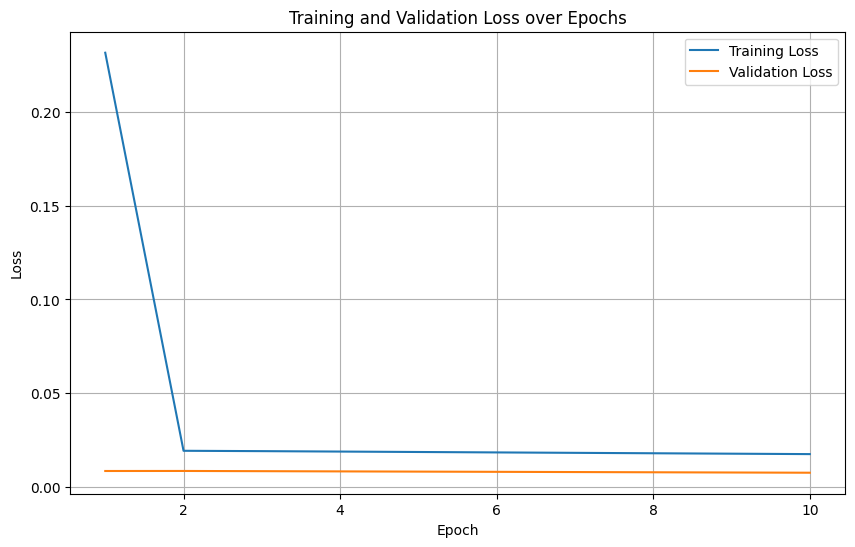

MLP Test Loss (MSE): 0.0106


In [49]:
# Extract features and target
X = data[['gpa', 'gender', 'concept']].values
y = data['iq'].values.astype(float)

# normalize features and target
X /= X.max(axis=0)
y /= 100.0

# Set random seed for reproducibility
random.seed(42)
np.random.seed(42)  # For numpy operations if needed

# Generate shuffled indices
indices = list(range(len(X)))
random.shuffle(indices)

# Split the indices into 80% train, 10% validation, 10% test in order provided by indices.
X_train, y_train = X[indices[:int(np.floor(0.8*len(indices)))],:], y[indices[:int(np.floor(0.8*len(indices)))]] # To be filled
X_val, y_val = X[indices[int(np.floor(0.8*len(indices)))+1:int(np.floor(0.9*len(indices)))],:], y[indices[int(np.floor(0.8*len(indices)))+1:int(np.floor(0.9*len(indices)))]] # To be filled
X_test, y_test = X[indices[int(np.floor(0.9*len(indices)))+1:len(indices)],:], y[indices[int(np.floor(0.9*len(indices)))+1:len(indices)]] # To be filled

# Define the model
model = MLP(3, [4, 2, 1]) # to be filled. Try different architectures up to three hidden layers.

# Get the parameters
parameters = model.parameters()

# Hyperparameters
lr = 0.01  # To be filled. Try different learning rates.
num_epochs = 10  # To be filled. Try different number of epochs.
batch_size = 8

# Lists to store losses for plotting
train_losses = []
val_losses = []

num_batches = int(np.ceil(len(X_train) / batch_size))


for epoch in range(num_epochs):
    total_loss = 0

    for batch_idx in range(num_batches):
      if batch_idx < num_batches -1:
        #forward pass for each training batch
        preds = [model(x) for x in X_train[batch_idx*batch_size:(batch_idx+1)*batch_size]]
        #calculate the loss for each training batch
        loss = [(ytrue - ypred)**2 for ytrue, ypred in zip(y_train[batch_idx*batch_size:(batch_idx+1)*batch_size], preds)]
        loss = sum(loss)
        total_loss += loss.data

        #reset all gradients for each batch
        for p in model.parameters():
          p.grad = 0.0

        #backward pass for each training batch
        loss.backward()

        #update the weights and biases after each batch
        for p in model.parameters():
          p.data += -lr * p.grad

      #forward pass for the last batch
      preds = [model(x) for x in X_train[(num_batches-1)*batch_size:]]
      #calculate the loss for the last batch
      loss = [(ytrue - ypred)**2 for ytrue, ypred in zip(y_train[(num_batches-1)*batch_size:], preds)]
      loss = sum(loss)
      total_loss += loss.data

      #reset the gradients for the last batch
      for p in model.parameters():
        p.grad = 0.0
      #backward pass for the last batch
      loss.backward()
      #update the weights and biases after the last batch
      for p in model.parameters():
        p.data += -lr * p.grad
      # Here the lacking code should be included...
    avg_loss = total_loss / len(X_train)
    train_losses.append(avg_loss)
    print(f"Epoch {epoch + 1}, Training Loss: {avg_loss:.4f}")

    # Evaluate on the validation set
    val_loss = 0.0
    for x_i, y_i in zip(X_val, y_val):
        x_values = [Value(x) for x in x_i]
        y_pred = model(x_values)
        loss = (y_pred - Value(y_i)) ** 2
        val_loss += loss.data

    avg_val_loss = val_loss / len(X_val)
    val_losses.append(avg_val_loss)
    print(f"Validation Loss: {avg_val_loss:.4f}")

# Plot the training and validation loss over epochs
plt.figure(figsize=(10, 6))
plt.plot(range(1, num_epochs + 1), train_losses, label='Training Loss')
plt.plot(range(1, num_epochs + 1), val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss over Epochs')
plt.legend()
plt.grid(True)
plt.show()

# After training, evaluate on the test set using MLP
mlp_test_loss = 0.0
for x_i, y_i in zip(X_test, y_test):
    x_values = [Value(x) for x in x_i]
    y_pred = model(x_i)
    loss = (y_pred - y_i) ** 2
    mlp_test_loss += loss.data

avg_mlp_test_loss = mlp_test_loss / len(X_test)
print(f"MLP Test Loss (MSE): {avg_mlp_test_loss:.4f}")


Compare the results with linear regression by evaluating how your MLP predictions align with those generated by a simple Linear Regression model.


Linear Regression Coefficients (theta):
[0.33491141 0.10324924 0.14025877 0.67918511]
Linear Regression Test Loss (MSE): 0.0071

Comparison of Test Losses:
MLP Test Loss (MSE): 0.0106
Linear Regression Test Loss (MSE): 0.0071


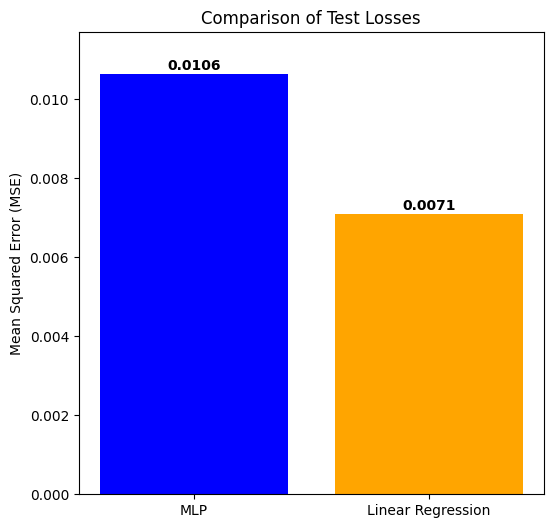

In [50]:
# ---------------------------------------------------
# Linear Regression Comparison
# ---------------------------------------------------

# Add a column of ones to X_train and X_test for the intercept term
ones_train = np.ones((X_train.shape[0], 1))
X_train_lr = np.hstack((X_train, ones_train))

ones_test = np.ones((X_test.shape[0], 1))
X_test_lr = np.hstack((X_test, ones_test))

# Compute theta using the closed-form solution on the training set
XT_X = np.matmul(X_train_lr.T, X_train_lr)
XT_X_inv = np.linalg.inv(XT_X)
XT_y = np.matmul(X_train_lr.T, y_train)
theta = np.matmul(XT_X_inv, XT_y)

print("\nLinear Regression Coefficients (theta):")
print(theta)

# Make predictions on the test set
y_pred_lr = np.matmul(X_test_lr, theta)

# Compute Mean Squared Error for Linear Regression on the test set
mse_lr = np.mean((y_pred_lr - y_test) ** 2)
print(f"Linear Regression Test Loss (MSE): {mse_lr:.4f}")

# Compare with MLP Test Loss
print("\nComparison of Test Losses:")
print(f"MLP Test Loss (MSE): {avg_mlp_test_loss:.4f}")
print(f"Linear Regression Test Loss (MSE): {mse_lr:.4f}")

labels = ['MLP', 'Linear Regression']
test_losses = [avg_mlp_test_loss, mse_lr]

plt.figure(figsize=(6, 6))
plt.bar(labels, test_losses, color=['blue', 'orange'])
plt.ylabel('Mean Squared Error (MSE)')
plt.title('Comparison of Test Losses')
for i, v in enumerate(test_losses):
    plt.text(i, v + 0.01 * max(test_losses), f"{v:.4f}", ha='center', fontweight='bold')
plt.ylim(0, max(test_losses) * 1.1)
plt.show()